In [1]:
# import all necessary packages for SS_LSTM
! pip install -q datasets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from torchtext.vocab import GloVe
from datasets import load_dataset
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64",

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Load Dataset from Hugging Face: Paws

In [74]:
# Load the data

def load_data():
    dataset = load_dataset("paws", "labeled_final")
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    val_dataset = dataset['validation']
    return train_dataset, val_dataset, test_dataset


In [75]:
# Load datasets
ltrain_dataset, lval_dataset, ltest_dataset = load_data()

In [76]:
# Check datasets
print(type(ltrain_dataset))

<class 'datasets.arrow_dataset.Dataset'>


### Preprocess Sentences

In [77]:
class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        self.sentences = [word_tokenize(sentence) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        stop_words = set(stopwords.words('english'))
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        stemmer = nltk.stem.PorterStemmer()
        self.sentences = [[stemmer.stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word != ' '] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]

    def run_all(self):
        self.tokenize()
        self.lowercase()
        self.remove_stop_words()
        self.stemmer()
        self.remove_punctuation()
        self.remove_numbers()
        self.remove_single_letter()
        self.remove_extra_spaces()
        self.remove_less_than_3()
        return self.sentences



### Create Embeddings Using Glove

In [8]:
# Load the GloVe embeddings
glove = GloVe(name='6B')
print(glove.vectors.shape)

.vector_cache/glove.6B.zip: 862MB [02:44, 5.26MB/s]                           
100%|█████████▉| 399999/400000 [00:53<00:00, 7537.10it/s]


torch.Size([400000, 300])


### Create Custom Dataset

In [78]:
def sentence_to_indices(sentence, glove, max_len):
    preprocess = Preprocess([sentence])
    # print(sentence)
    sentence = preprocess.run_all()[0]
    length = len(sentence)
    indices = [glove.stoi[word] if word in glove.stoi else glove.stoi['unk'] for word in sentence]
    padded_indices = indices[:max_len] + [0] * (max_len - len(indices))
    flength = length if length < max_len else max_len
    return padded_indices, max_len

def process_dataset(dataset, glove, max_len):
    processed_data = []
    for item in dataset:
        # print(item['id'])
        sentence1_indices, len1 = sentence_to_indices(item['sentence1'], glove, max_len)
        sentence2_indices, len2 = sentence_to_indices(item['sentence2'], glove, max_len)
        label = torch.tensor(item['label'], dtype=torch.long)
        sentence1_tensor = torch.tensor(sentence1_indices, dtype=torch.long)
        sentence2_tensor = torch.tensor(sentence2_indices, dtype=torch.long)
        processed_data.append((sentence1_indices, sentence2_indices, max_len, max_len, label))
    return processed_data

def collate_fn(batch):
    sentence1_batch = torch.tensor([item[0] for item in batch])
    sentence2_batch = torch.tensor([item[1] for item in batch])
    len1_batch = torch.tensor([item[2] for item in batch])
    len2_batch = torch.tensor([item[3] for item in batch])
    labels_batch = torch.tensor([item[4] for item in batch])
    return sentence1_batch, sentence2_batch, len1_batch, len2_batch, labels_batch


In [79]:
# Get the dataset
train_dataset = process_dataset(ltrain_dataset, glove, 37)
val_dataset = process_dataset(lval_dataset, glove, 37)
test_dataset = process_dataset(ltest_dataset, glove, 37)

In [13]:
# Check the dataset
print(train_dataset[1])
print(val_dataset[0])
print(test_dataset[0])

([2809, 195, 195, 513, 389991, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [195, 513, 389991, 201534, 195, 2809, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 37, 37, tensor(1))
([291910, 249628, 201534, 174620, 29972, 725, 603, 648, 201534, 695, 52, 725, 603, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [291910, 249628, 52, 201534, 174620, 353, 695, 725, 603, 725, 603, 648, 201534, 29972, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 37, 37, tensor(0))
([25335, 9857, 20985, 1224, 201534, 72957, 213766, 94, 751, 201534, 10158, 201534, 45909, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [25335, 9857, 10158, 2121, 201534, 72957, 213766, 94, 3133, 201534, 20985, 201534, 45909, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 37, 37, tensor(0))


### Use DataLoader

In [80]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [81]:
# # Check the dataloaders

print(len(train_loader))

for batch in train_loader:
    print(batch)
    break

386
(tensor([[    52,   2876,    368,  ...,      0,      0,      0],
        [   510, 201534,  14096,  ...,      0,      0,      0],
        [  3423,  34019,     54,  ...,      0,      0,      0],
        ...,
        [  1866,     62,   3313,  ...,      0,      0,      0],
        [201534, 201534, 201534,  ...,      0,      0,      0],
        [201534,    483, 201534,  ...,      0,      0,      0]]), tensor([[    52,   2876,    368,  ...,      0,      0,      0],
        [   510,   1131,   2662,  ...,      0,      0,      0],
        [  3423,  34019,     54,  ...,      0,      0,      0],
        ...,
        [  3313,  54189,     62,  ...,      0,      0,      0],
        [201534, 201534, 201534,  ...,      0,      0,      0],
        [   614,   2362,    628,  ...,      0,      0,      0]]), tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 3

### Create Model

In [82]:
# Avg model
class SS_AvgSum(nn.Module):
    def __init__(self, embedding_dim):
        super(SS_AvgSum, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(len(glove.vectors), embedding_dim)
        self.embedding.weight.data.copy_(glove.vectors)
        self.embedding.weight.requires_grad = False # Freeze embeddings
        self.fc = nn.Linear(2*embedding_dim, 1)

    def forward(self, batch):
        # Get the sentence pair and length
        sentence1, sentence2, len1, len2, _ = batch

        # Get the embeddings
        sentence1_embedding = self.embedding(sentence1)
        sentence2_embedding = self.embedding(sentence2)

        # Get average of embeddings
        avg_sentence1_embedding = torch.mean(sentence1_embedding, dim=1)
        avg_sentence2_embedding = torch.mean(sentence2_embedding, dim=1)

        # Concatenate the embeddings
        concatenated_embeddings = torch.cat((avg_sentence1_embedding, avg_sentence2_embedding), dim=1)

        # Get the output
        output = self.fc(concatenated_embeddings)
        output = torch.sigmoid(output)

        return output


### Train Model

In [83]:
# Set the hyperparameters
embedding_dim = 300
hidden_dim = 50
lr = 0.01
epochs = 10

# Initialize the model
model = SS_AvgSum(embedding_dim)
model.to(device)

# Define the loss function for binary classification
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# print(len(glove.vectors))


In [84]:
# Function for train
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_preds = []
        labels = []
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        for batch in tqdm(train_loader):
            batch = [b.to(device) if i != 2 and i != 3 else b for i, b in enumerate(batch)]
            # Get the output from the model
            # output1, output2 = model(batch)
            output = model(batch)

            # Get the label
            _, _, _, _, label = batch
            label = label.float()

            # Calculate the loss

            # output1 = F.normalize(output1, p=2, dim=1) # Normalize the output
            # output2 = F.normalize(output2, p=2, dim=1) # Normalize the output

            # cosine_similarity = F.cosine_similarity(output1, output2)
            # Round cosine similarity to 6 decimal places
            # cosine_similarity = torch.round(cosine_similarity * 1000000) / 1000000

            # Map the similarity to 0 or 1
            # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping
            # similarity = (cosine_similarity + 1)/2 # Linear mapping
            # print("Similarity range: min =", similarity.min().item(), "max =", similarity.max().item())

            # distance = F.mse_loss(output1, output2, reduction='none')
            # distance = torch.sum(distance, dim=1)
            # similarity = F.sigmoid(-distance)

            similarity = output.squeeze()

            loss = criterion(similarity, label)

            # Backpropagate the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the train loss
            train_loss += loss.item()

            # Get the predictions
            preds = [1 if x >= 0.5 else 0 for x in similarity]
            train_preds.extend(preds)
            # Detach the label from GPU
            label = label.detach().cpu().numpy()
            labels.extend(label)

        # Calculate the average loss
        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)

        # Calculate the validation loss
        model.eval()
        for batch in tqdm(val_loader):
            batch = [b.to(device) if i != 2 and i != 3 else b for i, b in enumerate(batch)]
            # Get the output from the model
            # output1, output2 = model(batch)
            output = model(batch)

            # Get the label
            _, _, _, _, label = batch
            label = label.float()

            # Calculate the loss

            # cosine_similarity = F.cosine_similarity(output1, output2)
            # Map the similarity to 0 or 1
            # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping

            similarity = output.squeeze()
            loss = criterion(similarity, label)

            # Update the validation loss
            val_loss += loss.item()

        # Calculate the average loss
        val_loss = val_loss/len(val_loader)
        val_losses.append(val_loss)

        # Calculate the accuracy
        train_acc = accuracy_score(train_preds, labels)

        # Print the losses and accuracy
        print("Epoch:", epoch+1, "Train Loss:", train_loss, "Val Loss:", val_loss, "Train Accuracy:", train_acc)

    return train_losses, val_losses

In [85]:
# Train the model

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs)

100%|██████████| 63/63 [00:00<00:00, 223.91it/s]


Epoch: 1 Train Loss: 0.6940842261586164 Val Loss: 0.6898031641566564 Train Accuracy: 0.5359405680046962


100%|██████████| 63/63 [00:00<00:00, 409.44it/s]


Epoch: 2 Train Loss: 0.6901105243924985 Val Loss: 0.68634285434844 Train Accuracy: 0.5479241310904638


100%|██████████| 63/63 [00:00<00:00, 345.17it/s]


Epoch: 3 Train Loss: 0.6895159916865393 Val Loss: 0.6946063003842793 Train Accuracy: 0.5467298232829295


100%|██████████| 63/63 [00:00<00:00, 408.92it/s]


Epoch: 4 Train Loss: 0.68869513844579 Val Loss: 0.7300308933333745 Train Accuracy: 0.5504746867472319


100%|██████████| 63/63 [00:00<00:00, 229.54it/s]


Epoch: 5 Train Loss: 0.6905731940207703 Val Loss: 0.6857126478164915 Train Accuracy: 0.5469524908402664


100%|██████████| 63/63 [00:00<00:00, 404.63it/s]


Epoch: 6 Train Loss: 0.6902018221857634 Val Loss: 0.6877658054942176 Train Accuracy: 0.5511831744296675


100%|██████████| 63/63 [00:00<00:00, 401.82it/s]


Epoch: 7 Train Loss: 0.6889116286922613 Val Loss: 0.7065660253403678 Train Accuracy: 0.5523977247424141


100%|██████████| 63/63 [00:00<00:00, 391.42it/s]


Epoch: 8 Train Loss: 0.6875312580036993 Val Loss: 0.690368978750138 Train Accuracy: 0.5551911904617316


100%|██████████| 63/63 [00:00<00:00, 368.20it/s]


Epoch: 9 Train Loss: 0.6881332554965439 Val Loss: 0.6859063156067379 Train Accuracy: 0.5531871824456995


100%|██████████| 63/63 [00:00<00:00, 351.32it/s]


Epoch: 10 Train Loss: 0.6906092835522686 Val Loss: 0.6866875669312855 Train Accuracy: 0.5488148013198113


In [86]:
# Function to plot the losses: train and validation on the same plot
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    # plt.savefig('/content/drive/MyDrive/ss_avgsum_losses.png')
    plt.show()

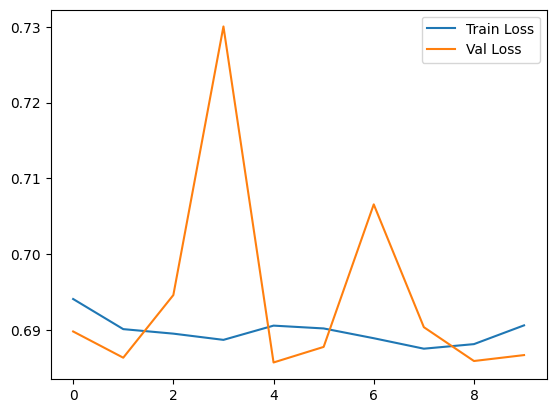

In [87]:
# Call the function to plot the losses
plot_losses(train_losses, val_losses)

In [88]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/ss_avgsum_losses.pth')

In [46]:
# load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/ss_avgsum_losses.pth'))

<All keys matched successfully>

### Test the Model

In [89]:
# Function for test
def evaluate(model, test_loader, criterion):
    test_loss = 0.0
    model.eval()
    predictions = []
    labels = []

    for batch in tqdm(test_loader):
        batch = [b.to(device) if i != 2 and i != 3 else b for i, b in enumerate(batch)]
        # Get the output from the model
        # output1, output2 = model(batch)
        output = model(batch)

        # Get the label
        _, _, _, _, label = batch
        label = label.float()

        # Calculate the loss

        # cosine_similarity = F.cosine_similarity(output1, output2)
        # Round cosine similarity to 6 decimal places
        # cosine_similarity = torch.round(cosine_similarity * 1000000) / 1000000

        # Map the similarity to 0 or 1
        # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping
        # similarity = (cosine_similarity + 1)/2 # Linear mapping

        similarity = output.squeeze()

        predicted_label = [1 if x >= 0.5 else 0 for x in similarity]
        predictions.extend(predicted_label)

        loss = criterion(similarity, label)

        label = label.detach().cpu().numpy()
        labels.extend(label.tolist())

        # Update the test loss
        test_loss += loss.item()

    # Calculate the average loss
    test_loss = test_loss/len(test_loader)

    # Print the losses
    print('Test Loss: {:.6f}'.format(test_loss))

    # Calculate the accuracy
    accuracy = accuracy_score(labels, predictions)

    return test_loss, accuracy * 100

In [90]:
# Evaluate the model

test_loss, accuracy = evaluate(model, test_loader, criterion)
print('Accuracy: {:.6f}'.format(accuracy))

100%|██████████| 63/63 [00:00<00:00, 90.85it/s]

Test Loss: 0.687682
Accuracy: 55.487500
